In [46]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import math

In [47]:
KO_initialdf = pd.read_csv("KO_StockData.csv")

In [48]:
# using around 1 year of data for this, and RSI is calculated for 7 day chunks, in the future can write this as KO_initialdf.head(n * t) --
# where n is the size of the RSI chunk and t determines how long we use this strategy
KO_df = KO_initialdf.head(7 * 52)
KO_df

,Dates,PX_LAST,PX_VOLUME
0,#NAME?,211.28,64953
1,1/3/2018,209.00,42276
2,1/4/2018,205.51,56186
3,1/5/2018,202.00,54218
4,1/8/2018,208.95,59956
...,...,...,...
359,6/7/2019,310.53,40705
360,6/10/2019,312.43,54176
361,6/11/2019,317.59,56950
362,6/12/2019,310.85,36984


In [49]:
#PX_VOLUME column is unneeded for this strategy (at least for the intro stages)
del KO_df["PX_VOLUME"]

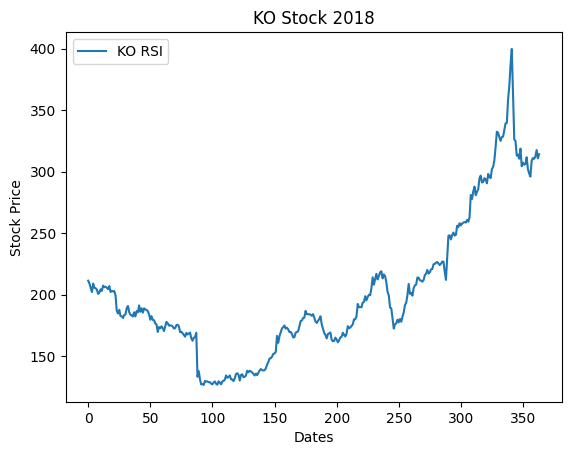

In [50]:
import matplotlib.pyplot as plt
x1 = range(len(KO_df["Dates"]))
y1 = KO_df["PX_LAST"]

plt.plot(x1, y1, label="KO RSI")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.title("KO Stock 2018")
plt.legend()
plt.show()

In [51]:
# .diff() helps us find the difference in a certain column -- in this case the "Change" column has the value difference of the stock each day
KO_df["Change"] = KO_df["PX_LAST"].diff()
KO_df

,Dates,PX_LAST,Change
0,#NAME?,211.28,NaN
1,1/3/2018,209.00,-2.28
2,1/4/2018,205.51,-3.49
3,1/5/2018,202.00,-3.51
4,1/8/2018,208.95,6.95
...,...,...,...
359,6/7/2019,310.53,-0.52
360,6/10/2019,312.43,1.90
361,6/11/2019,317.59,5.16
362,6/12/2019,310.85,-6.74


In [52]:
#make two dummy columns for Upward and Downward Movement, they will be edited next
KO_df["UpwardMovement"] = KO_df["Change"]
KO_df["DownwardMovement"] = KO_df["Change"]

#the upward movement columns can only have positive values, so if there is a negative value, we default it to zero
for i in range(len(KO_df) - 1):
  if (KO_df["UpwardMovement"].iloc[i] < 0):
    KO_df["UpwardMovement"].iloc[i] = 0

#the downward movement columns can only have negative values, so if there is a positve value, we default it to zero
for i in range(len(KO_df) - 1):
  if (KO_df["DownwardMovement"].iloc[i] > 0):
    KO_df["DownwardMovement"].iloc[i] = 0

# to calculate RSI correctly, we need to absolute value of all downward movement
  KO_df["DownwardMovement"].iloc[i] = abs(KO_df["DownwardMovement"].iloc[i])

KO_df



,Dates,PX_LAST,Change,UpwardMovement,DownwardMovement
0,#NAME?,211.28,NaN,NaN,NaN
1,1/3/2018,209.00,-2.28,0.00,2.28
2,1/4/2018,205.51,-3.49,0.00,3.49
3,1/5/2018,202.00,-3.51,0.00,3.51
4,1/8/2018,208.95,6.95,6.95,0.00
...,...,...,...,...,...
359,6/7/2019,310.53,-0.52,0.00,0.52
360,6/10/2019,312.43,1.90,1.90,0.00
361,6/11/2019,317.59,5.16,5.16,0.00
362,6/12/2019,310.85,-6.74,0.00,6.74


In [53]:
# makes two dummy columns that we will edit next
KO_df["AvgUp"] = 0
KO_df["AvgDown"] = 0

n = 7

#for the first n-1 days, we have no average since the period we calculate RSI is over n days
#to find the very first average movement, we just sum up all the values in the column and divide by the number of values
for i in range(1, n - 1):
  KO_df["AvgUp"].iloc[n - 1] += KO_df["UpwardMovement"].iloc[i]

for i in range(1, n - 1):
  KO_df["AvgDown"].iloc[n - 1] += KO_df["DownwardMovement"].iloc[i]

#from here, we use a weighted/moving average
#we take the previous day's average and multiply it by (n - 1), then we add today's value and divide everything by n
for i in range(n, len(KO_df)):
  KO_df["AvgUp"].iloc[i] = ((KO_df["AvgUp"].iloc[i - 1] * (n - 1)) + KO_df["UpwardMovement"].iloc[i]) / (n)

for i in range(n, len(KO_df)):
  KO_df["AvgDown"].iloc[i] = ((KO_df["AvgDown"].iloc[i - 1] * (n - 1)) + KO_df["DownwardMovement"].iloc[i]) / (n)


C:\Users\subbu\AppData\Local\Temp\ipykernel_16252\209828554.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.949999999999989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  KO_df["AvgUp"].iloc[n - 1] += KO_df["UpwardMovement"].iloc[i]
C:\Users\subbu\AppData\Local\Temp\ipykernel_16252\209828554.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.280000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  KO_df["AvgDown"].iloc[n - 1] += KO_df["DownwardMovement"].iloc[i]


In [54]:
#by definition, RS is the average upward movement over the average downward movement
KO_df["RS"] = KO_df["AvgUp"] / KO_df["AvgDown"]

In [55]:
#by definition, RSI = 100 * (RS/(RS + 1))
KO_df["RSI"] = 100 * (KO_df["RS"] / (KO_df["RS"] + 1))

KO_df

,Dates,PX_LAST,Change,UpwardMovement,DownwardMovement,AvgUp,AvgDown,RS,RSI
0,#NAME?,211.28,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,1/3/2018,209.00,-2.28,0.00,2.28,0.000000,0.000000,NaN,NaN
2,1/4/2018,205.51,-3.49,0.00,3.49,0.000000,0.000000,NaN,NaN
3,1/5/2018,202.00,-3.51,0.00,3.51,0.000000,0.000000,NaN,NaN
4,1/8/2018,208.95,6.95,6.95,0.00,0.000000,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...
359,6/7/2019,310.53,-0.52,0.00,0.52,2.825941,2.862912,0.987086,49.675058
360,6/10/2019,312.43,1.90,1.90,0.00,2.693664,2.453924,1.097696,52.328656
361,6/11/2019,317.59,5.16,5.16,0.00,3.045997,2.103364,1.448155,59.152918
362,6/12/2019,310.85,-6.74,0.00,6.74,2.610855,2.765740,0.943999,48.559632


In [56]:
#new data frame with just RSI and dates so we only see what we need
KO_RSI = KO_df[["Dates", "PX_LAST", "RSI"]]

KO_RSI.iloc[0:25]

,Dates,PX_LAST,RSI
0,#NAME?,211.28,NaN
1,1/3/2018,209.00,NaN
2,1/4/2018,205.51,NaN
3,1/5/2018,202.00,NaN
4,1/8/2018,208.95,NaN
5,1/9/2018,205.50,NaN
6,1/10/2018,205.18,35.315041
7,1/11/2018,203.96,34.953898
8,1/12/2018,200.51,33.813095
9,1/16/2018,201.69,34.663993


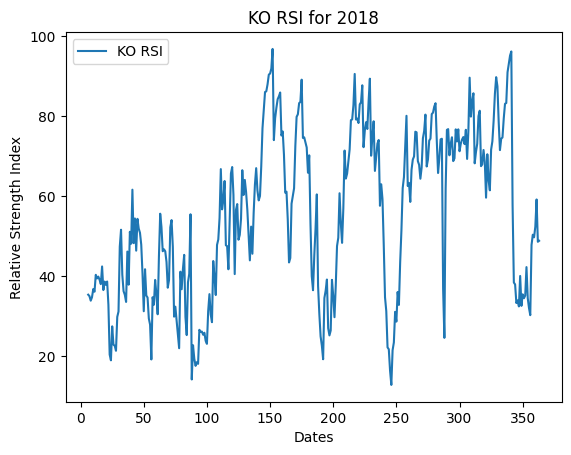

In [57]:
#plotting the RSI graph and the overvalued and undervalued boundaries
import matplotlib.pyplot as plt
x1 = range(len(KO_RSI["Dates"]))
y1 = KO_RSI["RSI"]

plt.plot(x1, y1, label="KO RSI")
plt.xlabel("Dates")
plt.ylabel("Relative Strength Index")
plt.title("KO RSI for 2018")
plt.legend()
plt.show()

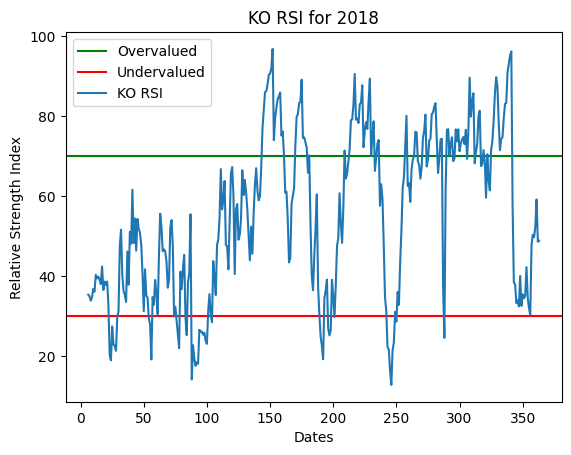

In [58]:
x1 = range(len(KO_RSI["Dates"]))
y1 = KO_RSI["RSI"]

plt.axhline(y=70, color = 'g', label="Overvalued")
plt.axhline(y=30, color = 'r', label="Undervalued")

plt.plot(x1, y1, label="KO RSI")
plt.xlabel("Dates")
plt.ylabel("Relative Strength Index")
plt.title("KO RSI for 2018")
plt.legend()
plt.show()

In [59]:
# initial value we invest when RSI goes below 30
# take out our amount when it goes above 70

initial = 100
value = initial

if KO_RSI["PX_LAST"].iloc[7] <= 30:
  status = "Buying"
else:
  status = "No Investment"

values = []
values = [initial]*7
PortfolioStatus = []
last_move_day = 7

transaction_values = []

for i in range(7, len(KO_RSI) - 1):

  if status == "Buying":
    a = "Buying: Day " + str(i)
    PortfolioStatus.append(a)

    status = "Invested"
    #value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])
    last_move_day = i
    transaction_values.append(value)

  if status == "Selling":
    a = "Selling: Day " + str(i)
    PortfolioStatus.append(a)

    status = "No Investment"
    value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])
    last_move_day = i
    transaction_values.append(value)

  # if status == "Invested":
  #   value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])

  if ((KO_RSI["RSI"].iloc[i] > 30) and (KO_RSI["RSI"].iloc[i + 1] <= 30) and (status == "No Investment")):
    status = "Buying"

  if ((KO_RSI["RSI"].iloc[i] < 70) and (KO_RSI["RSI"].iloc[i + 1] >= 70) and (status == "Invested")):
    status = "Selling"

  values.append(value)

print(PortfolioStatus)
print(transaction_values)
#print(values)
print(value)







['Buying: Day 23', 'Selling: Day 144', 'Buying: Day 190', 'Selling: Day 209', 'Buying: Day 243', 'Selling: Day 257', 'Buying: Day 288', 'Selling: Day 290']
[100, 76.5399035886449, 76.5399035886449, 79.05691766055921, 79.05691766055921, 83.30105222880186, 83.30105222880186, 97.40988302241381]
97.40988302241381


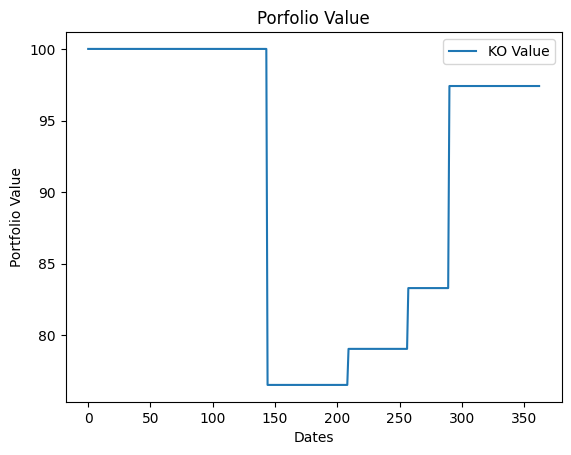

In [60]:
x1 = range(len(KO_RSI) - 1)
y1 = values

plt.plot(x1, y1, label="KO Value")
plt.xlabel("Dates")
plt.ylabel("Portfolio Value")
plt.title("Porfolio Value")
plt.legend()
plt.show()

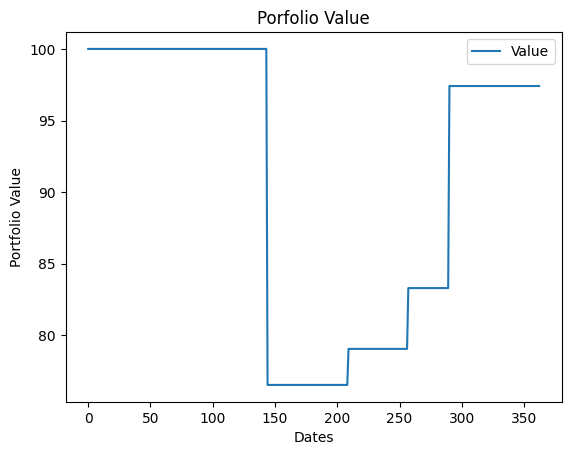

Profit: $-2.5901169775861916
A -2.5901169775861916% gain!


In [61]:
x1 = range(len(KO_RSI) - 1)
y1 = values

plt.plot(x1, y1, label="Value")
plt.xlabel("Dates")
plt.ylabel("Portfolio Value")
plt.title("Porfolio Value")
plt.legend()
plt.show()

print("Profit: $" + str(value - initial))
print("A " + str(100*(value - initial)/initial) + "% gain!")

In [62]:
KO_df = KO_initialdf
KO_df

,Dates,PX_LAST,PX_VOLUME
0,#NAME?,211.28,64953
1,1/3/2018,209.00,42276
2,1/4/2018,205.51,56186
3,1/5/2018,202.00,54218
4,1/8/2018,208.95,59956
...,...,...,...
811,3/24/2021,282.36,27427
812,3/25/2021,289.91,31005
813,3/26/2021,297.56,14624
814,3/29/2021,302.70,25053


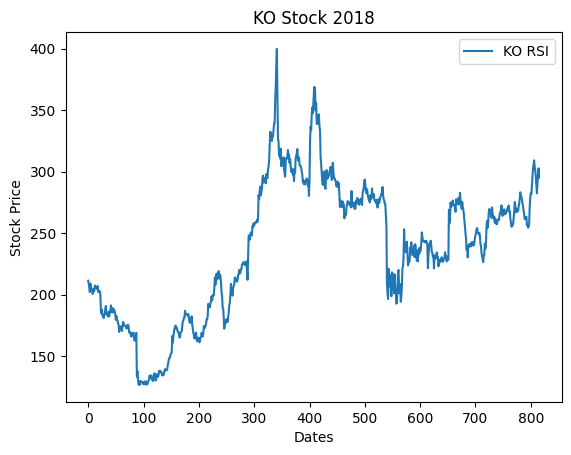

In [63]:
del KO_df["PX_VOLUME"]

x1 = range(len(KO_df["Dates"]))
y1 = KO_df["PX_LAST"]

plt.plot(x1, y1, label="KO RSI")
plt.xlabel("Dates")
plt.ylabel("Stock Price")
plt.title("KO Stock 2018")
plt.legend()
plt.show()

C:\Users\subbu\AppData\Local\Temp\ipykernel_16252\287273611.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.949999999999989' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  KO_df["AvgUp"].iloc[n - 1] += KO_df["UpwardMovement"].iloc[i]
C:\Users\subbu\AppData\Local\Temp\ipykernel_16252\287273611.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.280000000000001' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  KO_df["AvgDown"].iloc[n - 1] += KO_df["DownwardMovement"].iloc[i]


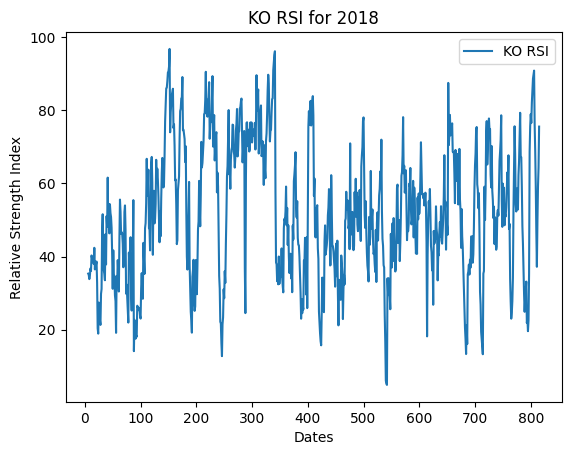

In [64]:
KO_df["Change"] = KO_df["PX_LAST"].diff()

#make two dummy columns for Upward and Downward Movement, they will be edited next
KO_df["UpwardMovement"] = KO_df["Change"]
KO_df["DownwardMovement"] = KO_df["Change"]

#the upward movement columns can only have positive values, so if there is a negative value, we default it to zero
for i in range(len(KO_df) - 1):
  if (KO_df["UpwardMovement"].iloc[i] < 0):
    KO_df["UpwardMovement"].iloc[i] = 0

#the downward movement columns can only have negative values, so if there is a positve value, we default it to zero
for i in range(len(KO_df) - 1):
  if (KO_df["DownwardMovement"].iloc[i] > 0):
    KO_df["DownwardMovement"].iloc[i] = 0

# to calculate RSI correctly, we need to absolute value of all downward movement
  KO_df["DownwardMovement"].iloc[i] = abs(KO_df["DownwardMovement"].iloc[i])

# makes two dummy columns that we will edit next
KO_df["AvgUp"] = 0
KO_df["AvgDown"] = 0

n = 7

#for the first n-1 days, we have no average since the period we calculate RSI is over n days
#to find the very first average movement, we just sum up all the values in the column and divide by the number of values
for i in range(1, n - 1):
  KO_df["AvgUp"].iloc[n - 1] += KO_df["UpwardMovement"].iloc[i]

for i in range(1, n - 1):
  KO_df["AvgDown"].iloc[n - 1] += KO_df["DownwardMovement"].iloc[i]

#from here, we use a weighted/moving average
#we take the previous day's average and multiply it by (n - 1), then we add today's value and divide everything by n
for i in range(n, len(KO_df)):
  KO_df["AvgUp"].iloc[i] = ((KO_df["AvgUp"].iloc[i - 1] * (n - 1)) + KO_df["UpwardMovement"].iloc[i]) / (n)

for i in range(n, len(KO_df)):
  KO_df["AvgDown"].iloc[i] = ((KO_df["AvgDown"].iloc[i - 1] * (n - 1)) + KO_df["DownwardMovement"].iloc[i]) / (n)

KO_df["RS"] = KO_df["AvgUp"] / KO_df["AvgDown"]
KO_df["RSI"] = 100 * (KO_df["RS"] / (KO_df["RS"] + 1))

KO_RSI = KO_df[["Dates", "PX_LAST", "RSI"]]

KO_RSI

x1 = range(len(KO_RSI["Dates"]))
y1 = KO_RSI["RSI"]

plt.plot(x1, y1, label="KO RSI")
plt.xlabel("Dates")
plt.ylabel("Relative Strength Index")
plt.title("KO RSI for 2018")
plt.legend()
plt.show()

In [65]:
initial = 100
value = initial

if KO_RSI["PX_LAST"].iloc[7] <= 30:
  status = "Buying"
else:
  status = "No Investment"

values = []
values = [initial]*7
PortfolioStatus = []
last_move_day = 7

transaction_values = []

for i in range(7, len(KO_RSI) - 1):

  if status == "Buying":
    a = "Buying: Day " + str(i)
    PortfolioStatus.append(a)

    status = "Invested"
    #value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])
    last_move_day = i
    transaction_values.append(value)

  if status == "Selling":
    a = "Selling: Day " + str(i)
    PortfolioStatus.append(a)

    status = "No Investment"
    value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])
    last_move_day = i
    transaction_values.append(value)

  # if status == "Invested":
  #   value *= (KO_RSI["PX_LAST"].iloc[i] / KO_RSI["PX_LAST"].iloc[last_move_day])

  if ((KO_RSI["RSI"].iloc[i] > 30) and (KO_RSI["RSI"].iloc[i + 1] <= 30) and (status == "No Investment")):
    status = "Buying"

  if ((KO_RSI["RSI"].iloc[i] < 70) and (KO_RSI["RSI"].iloc[i + 1] >= 70) and (status == "Invested")):
    status = "Selling"

  values.append(value)

print(PortfolioStatus)
print(transaction_values)
#print(values)
print(value)

['Buying: Day 23', 'Selling: Day 144', 'Buying: Day 190', 'Selling: Day 209', 'Buying: Day 243', 'Selling: Day 257', 'Buying: Day 288', 'Selling: Day 290', 'Buying: Day 388', 'Selling: Day 401', 'Buying: Day 420', 'Selling: Day 476', 'Buying: Day 538', 'Selling: Day 571', 'Buying: Day 614', 'Selling: Day 652', 'Buying: Day 681', 'Selling: Day 702', 'Buying: Day 710', 'Selling: Day 720', 'Buying: Day 764', 'Selling: Day 771', 'Buying: Day 788', 'Selling: Day 799']
[100, 76.5399035886449, 76.5399035886449, 79.05691766055921, 79.05691766055921, 83.30105222880186, 83.30105222880186, 97.40988302241381, 97.40988302241381, 108.62002920606237, 108.62002920606237, 98.70254827855233, 98.70254827855233, 94.21099437370341, 94.21099437370341, 114.39876082935142, 114.39876082935142, 113.91822585472178, 113.91822585472178, 121.71882173073173, 121.71882173073173, 129.58485998389537, 129.58485998389537, 136.2578345013385]
136.2578345013385


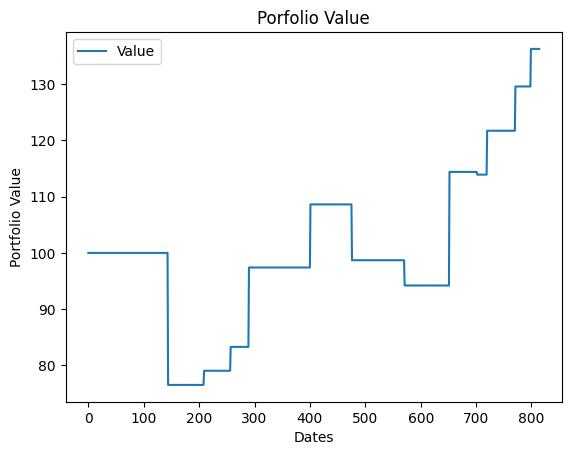

Profit: $36.25783450133849
A 36.25783450133849% gain!


In [66]:
x1 = range(len(KO_RSI) - 1)
y1 = values

plt.plot(x1, y1, label="Value")
plt.xlabel("Dates")
plt.ylabel("Portfolio Value")
plt.title("Porfolio Value")
plt.legend()
plt.show()

print("Profit: $" + str(value - initial))
print("A " + str(100*(value - initial)/initial) + "% gain!")